**Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np

x_healthy = []
x_patient = []

y_healthy = []
y_patient = []


path = '/content/drive/MyDrive/blast-cell/dataset/dataset'

for image in os.listdir(path):
  # print(image[-5])
  if image[-5] == '0':
    image = cv2.imread(path + '/' + image)
    image = cv2.resize(image, (257, 257))     
    x_healthy.append(image)
    y_healthy.append(0)

  elif image[-5] == '1':
    image = cv2.imread(path + '/' + image)
    image = cv2.resize(image, (257, 257))     
    x_patient.append(image)
    y_patient.append(1)


x_healthy = np.array(x_healthy)
y_healthy = np.array(y_healthy)

x_patient = np.array(x_patient)
y_patient = np.array(y_patient)




print(x_healthy.shape)
print(y_healthy.shape)

print(x_patient.shape)
print(y_patient.shape)





(130, 257, 257, 3)
(130,)
(130, 257, 257, 3)
(130,)


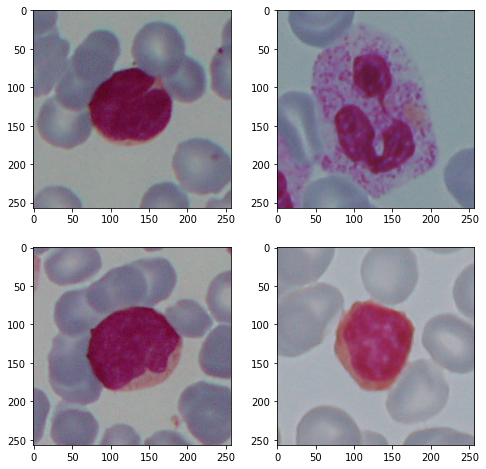

In [ ]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 2, figsize=(8,8))
axs[0, 0].imshow(np.squeeze(x_patient[20]), cmap='gray')
axs[0, 1].imshow(np.squeeze(x_healthy[50]), cmap='gray')
axs[1, 0].imshow(np.squeeze(x_patient[30]), cmap='gray')
axs[1, 1].imshow(np.squeeze(x_healthy[35]), cmap='gray')


**Augementation**

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa

ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5), # vertical flips
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (1, 1.2), "y": (1, 1.2)}, # scale images
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-5, 5),
        shear=(-5, 5)
    )
], random_order=True) # apply augmenters in random order

**Healthy Aug**

In [ ]:
num_augs = round(len(x_healthy)/2.)
rand_idx = np.random.randint(0, len(x_healthy), size=num_augs)

sample_x_healthy = [x_healthy[ii] for ii in rand_idx]


In [ ]:
seq_det = seq.to_deterministic()
x_healthy_aug = seq_det.augment_images(sample_x_healthy)


In [ ]:
x_healthy_aug = np.array(x_healthy_aug)
x_healthy_aug.shape

(65, 257, 257, 3)

**Patient Aug**

In [ ]:

num_augs = round(len(x_patient)/2.)
rand_idx = np.random.randint(0, len(x_patient), size=num_augs)

sample_x_patient = [x_patient[ii] for ii in rand_idx]


In [ ]:
seq_det = seq.to_deterministic()
x_patient_aug = seq_det.augment_images(sample_x_patient)


In [ ]:
x_patient_aug = np.array(x_patient_aug)
x_patient_aug.shape

(65, 257, 257, 3)

**Visualize Augmented data**

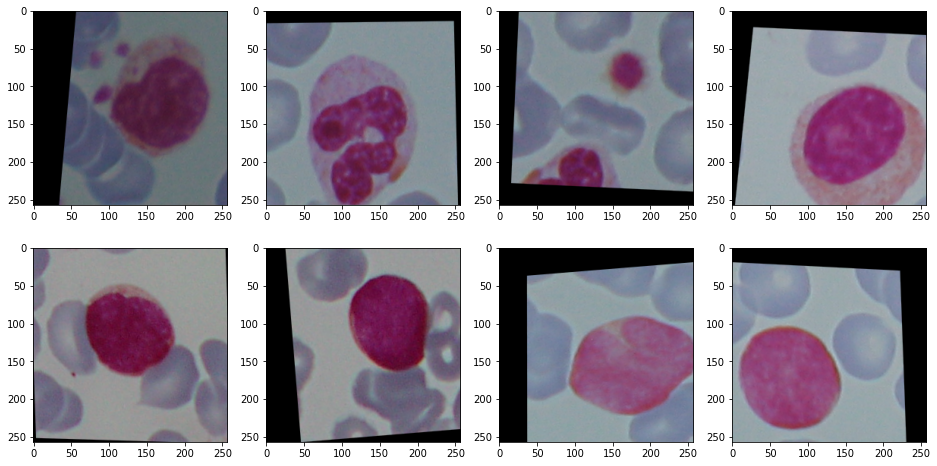

In [ ]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 4, figsize=(16,8))
axs[0, 0].imshow(np.squeeze(x_healthy_aug[20]), cmap='gray')
axs[0, 1].imshow(np.squeeze(x_healthy_aug[50]), cmap='gray')
axs[0, 2].imshow(np.squeeze(x_healthy_aug[60]), cmap='gray')
axs[0, 3].imshow(np.squeeze(x_healthy_aug[12]), cmap='gray')

axs[1, 0].imshow(np.squeeze(x_patient_aug[30]), cmap='gray')
axs[1, 1].imshow(np.squeeze(x_patient_aug[63]), cmap='gray')
axs[1, 2].imshow(np.squeeze(x_patient_aug[54]), cmap='gray')
axs[1, 3].imshow(np.squeeze(x_patient_aug[32]), cmap='gray')


**Merge dataset with augemented images**

In [ ]:

X = np.concatenate((x_healthy , x_patient, x_healthy_aug, x_patient_aug ), axis = 0)

y_healthy_aug = []
y_patient_aug = []

for i in range(len(x_healthy_aug)):
  y_healthy_aug.append(0)
  
for i in range(len(x_patient_aug)):
  y_patient_aug.append(1)
  
Y = np.concatenate((y_healthy, y_patient ,y_healthy_aug, y_patient_aug))

print(X.shape)
print(Y.shape)

(390, 257, 257, 3)
(390,)


**Split dataset into Train and Test 80%-20%**

In [ ]:
from sklearn.model_selection import train_test_split



X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42,
                                                    shuffle=True, stratify = Y)
print(X_train.shape)
print(X_test.shape)

(312, 257, 257, 3)
(78, 257, 257, 3)


In [ ]:
from keras.utils import to_categorical
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

**Define the model**

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 257, 257, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 129, 129, 8)       224       
_________________________________________________________________
activation (Activation)      (None, 129, 129, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0     

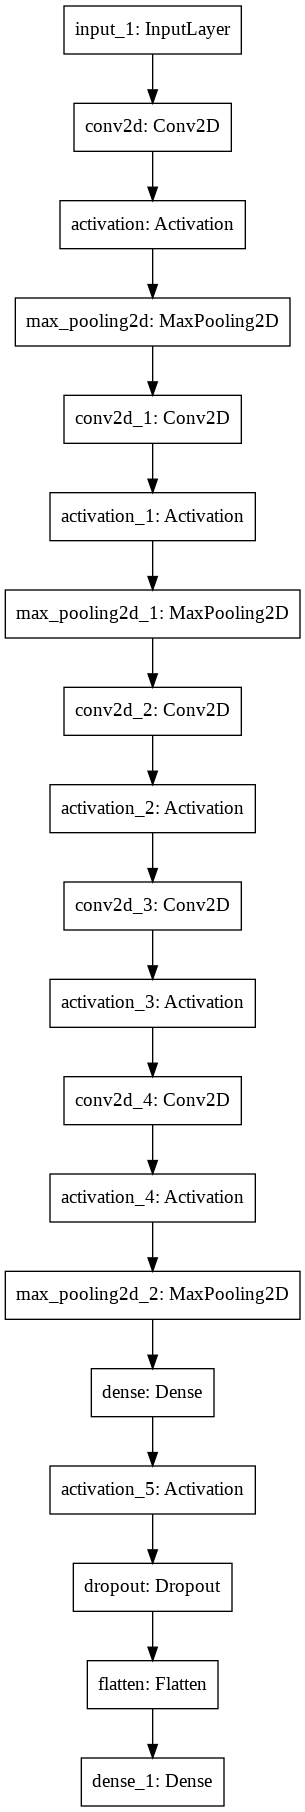

In [ ]:


import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Reshape, Conv2D, Dropout
from tensorflow.keras.layers import  Activation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.layers import ZeroPadding1D
from tensorflow.keras.models import Model



inputs = Input(shape=(257, 257,  3))

x = Conv2D(8, 3, padding='same', strides=(2, 2))(inputs)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2),  padding='valid')(x)

x = Conv2D(16, 3, padding='same', strides=(1, 1))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid')(x)

x = Conv2D(32, 5, padding='same', strides=1)(x)
x = Activation('relu')(x)

x = Conv2D(64, 3, padding='same',strides=1)(x)
x = Activation('relu')(x)

x = Conv2D(128, 3, padding='same',strides=1)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3),strides=(2, 2), padding='valid')(x)

x = Dense(1000, activation='relu')(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(2, activation='softmax')(x)


model= Model(inputs, x)
print(model.summary())
from keras.utils import plot_model
plot_model(model)

**Training the model**

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=500,
                    batch_size=100, verbose=1,
                    validation_data=(X_test, Y_test))

Epoch 1/500
4/4 [==============================] - 32s 471ms/step - loss: 4.6259 - accuracy: 0.5072 - val_loss: 5.8059 - val_accuracy: 0.5000
Epoch 2/500
4/4 [==============================] - 0s 111ms/step - loss: 5.4602 - accuracy: 0.5804 - val_loss: 1.5815 - val_accuracy: 0.5000
Epoch 3/500
4/4 [==============================] - 0s 110ms/step - loss: 1.8531 - accuracy: 0.5858 - val_loss: 1.5643 - val_accuracy: 0.5000
Epoch 4/500
4/4 [==============================] - 0s 109ms/step - loss: 1.4775 - accuracy: 0.4987 - val_loss: 0.7947 - val_accuracy: 0.7179
Epoch 5/500
4/4 [==============================] - 0s 108ms/step - loss: 0.9187 - accuracy: 0.6783 - val_loss: 1.0108 - val_accuracy: 0.5513
Epoch 6/500
4/4 [==============================] - 0s 109ms/step - loss: 0.6319 - accuracy: 0.7361 - val_loss: 0.6924 - val_accuracy: 0.6282
Epoch 7/500
4/4 [==============================] - 0s 110ms/step - loss: 0.7156 - accuracy: 0.6661 - val_loss: 0.6798 - val_accuracy: 0.6154
Epoch 8/500


**Train Metrics**

In [ ]:

from sklearn.metrics import classification_report

y_pred = np.around(model.predict(X_train))
rep = classification_report(Y_train, y_pred)
print(rep)

acc = accuracy_score(Y_train, y_pred)
print('Accuracy is:' , acc * 100)

conftrain =  confusion_matrix(Y_train.argmax(axis=1), y_pred.argmax(axis=1))
print(conftrain)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       1.00      1.00      1.00       156

   micro avg       1.00      1.00      1.00       312
   macro avg       1.00      1.00      1.00       312
weighted avg       1.00      1.00      1.00       312
 samples avg       1.00      1.00      1.00       312

Accuracy is: 100.0
[[156   0]
 [  0 156]]


**Test Metrics**

In [ ]:

from sklearn.metrics import classification_report

y_pred = np.around(model.predict(X_test))
rep = classification_report(Y_test, y_pred)
print(rep)

acc = accuracy_score(Y_test, y_pred)
print('Accuracy is:' , acc * 100)

conftest =  confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(conftest)

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        39
           1       0.95      0.90      0.92        39

   micro avg       0.92      0.92      0.92        78
   macro avg       0.92      0.92      0.92        78
weighted avg       0.92      0.92      0.92        78
 samples avg       0.92      0.92      0.92        78

Accuracy is: 92.3076923076923
[[37  2]
 [ 4 35]]


**Train and  Test Curves**

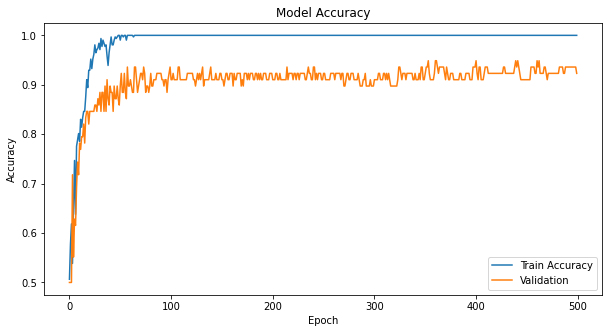

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"], label = 'Train Accuracy')
plt.plot(history.history["val_accuracy"],  label = 'Validation')
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()


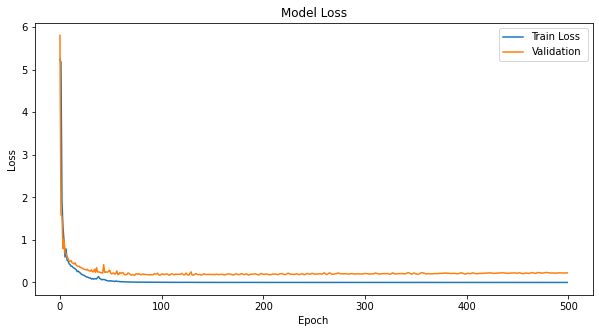

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"],  label = 'Train Loss ')
plt.plot(history.history["val_loss"],  label = 'Validation')
plt.title("Model Loss")       
plt.ylabel("Loss") 
plt.xlabel("Epoch")
plt.legend()

plt.show()
  

**Confusion Matrix**

*train*

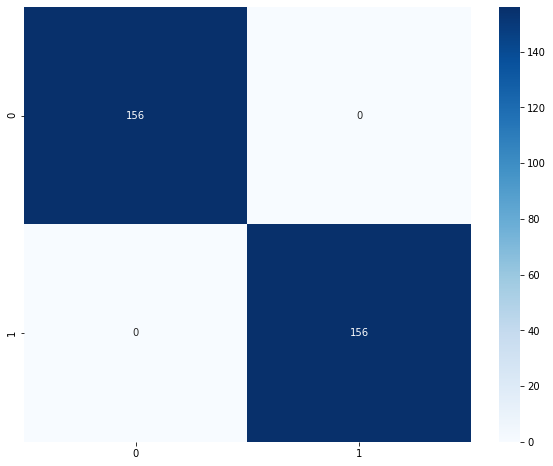

In [ ]:
import seaborn as sn

plt.figure(figsize = (10,8))
sn.heatmap(conftrain, cmap = 'Blues' ,annot=True, fmt='d')

*test*

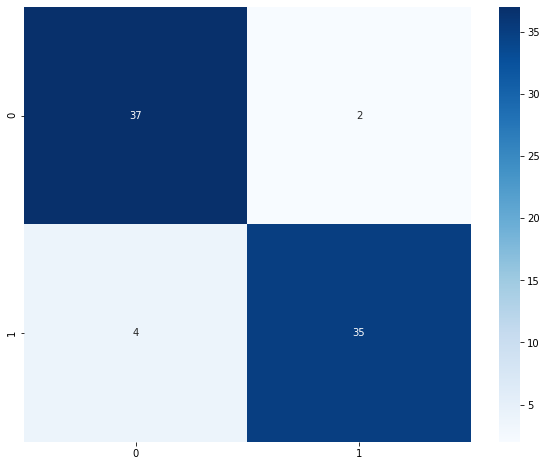

In [ ]:
import seaborn as sn

plt.figure(figsize = (10,8))
sn.heatmap(conftest, cmap = 'Blues' ,annot=True)

**Change network structure**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Add, BatchNormalization, concatenate
from tensorflow.keras.layers import AveragePooling2D, Dropout


def get_effnet(input_shape=(257, 257, 3), classes=2, included_layers=1):
  image_input = Input(input_shape)
  model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet',
  input_shape=input_shape, pooling=None) 
  for layer in model.layers[:-included_layers]:
    layer.trainable = False
  print(f'Training {included_layers} Layers from {len(model.layers)}...') 
  # add classification layers
  last_layer = model(image_input)
  if classes > 1:
    act = 'softmax'
  else:
    act = 'sigmoid'
  x = Flatten()(last_layer)
  x = Dropout(0.5)(x)
  x = Dense(1280, activation='relu')(x)
  x = Dropout(0.5)(x)
  out = Dense(classes, activation=act, name='output_layer')(x)
  custom_model = tf.keras.models.Model(inputs=image_input,outputs=out)

  return custom_model

43941888/43941136 [==============================] - 1s 0us/step
Training 1 Layers from 384...
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 257, 257, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 9, 9, 1536)        10783535  
_________________________________________________________________
flatten_16 (Flatten)         (None, 124416)            0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 124416)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 1280)              159253760 
_________________________________________________________________
dropout_41 (Dropout)         (None, 1280)              0         
_____________________________

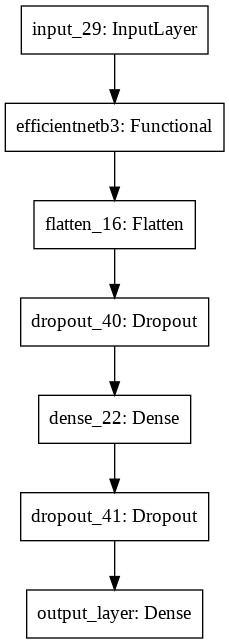

In [ ]:
from keras.utils import plot_model

model = get_effnet(input_shape=(257, 257, 3), classes=2, included_layers=1)
model.summary()
from keras.utils import plot_model
plot_model(model)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=50,
                    batch_size=128, verbose=1,
                    validation_data=(X_test, Y_test))

Epoch 1/50
3/3 [==============================] - 25s 5s/step - loss: 5.3757 - accuracy: 0.6267 - val_loss: 1.1575 - val_accuracy: 0.9103
Epoch 2/50
3/3 [==============================] - 4s 2s/step - loss: 1.5497 - accuracy: 0.8596 - val_loss: 1.0420 - val_accuracy: 0.8846
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 1.1767 - accuracy: 0.8640 - val_loss: 0.2649 - val_accuracy: 0.9103
Epoch 4/50
3/3 [==============================] - 4s 1s/step - loss: 0.5123 - accuracy: 0.8869 - val_loss: 0.4582 - val_accuracy: 0.8974
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 0.3477 - accuracy: 0.9322 - val_loss: 0.2602 - val_accuracy: 0.8846
Epoch 6/50
3/3 [==============================] - 4s 1s/step - loss: 0.2436 - accuracy: 0.9454 - val_loss: 0.2454 - val_accuracy: 0.9103
Epoch 7/50
3/3 [==============================] - 4s 1s/step - loss: 0.2947 - accuracy: 0.9308 - val_loss: 0.2407 - val_accuracy: 0.9487
Epoch 8/50
3/3 [========================

*Train*

In [ ]:

from sklearn.metrics import classification_report

y_pred = np.around(model.predict(X_train))
rep = classification_report(Y_train, y_pred)
print(rep)

acc = accuracy_score(Y_train, y_pred)
print('Accuracy is:' , acc * 100)

conftrain =  confusion_matrix(Y_train.argmax(axis=1), y_pred.argmax(axis=1))
print(conftrain)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       156
           1       1.00      1.00      1.00       156

   micro avg       1.00      1.00      1.00       312
   macro avg       1.00      1.00      1.00       312
weighted avg       1.00      1.00      1.00       312
 samples avg       1.00      1.00      1.00       312

Accuracy is: 100.0
[[156   0]
 [  0 156]]


*Test*

In [ ]:

from sklearn.metrics import classification_report

y_pred = np.around(model.predict(X_test))
rep = classification_report(Y_test, y_pred)
print(rep)

acc = accuracy_score(Y_test, y_pred)
print('Accuracy is:' , acc * 100)

conftest =  confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(conftest)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      0.97      0.99        39

   micro avg       0.99      0.99      0.99        78
   macro avg       0.99      0.99      0.99        78
weighted avg       0.99      0.99      0.99        78
 samples avg       0.99      0.99      0.99        78

Accuracy is: 98.71794871794873
[[39  0]
 [ 1 38]]


**Train and Test Curves**

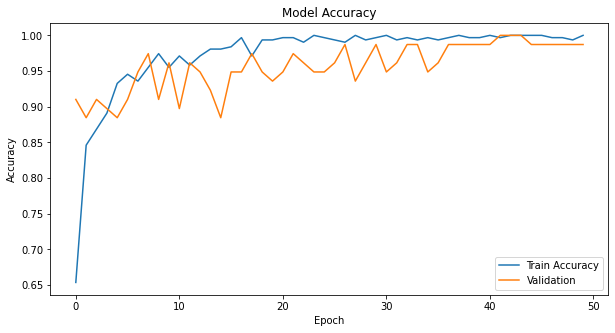

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"], label = 'Train Accuracy')
plt.plot(history.history["val_accuracy"],  label = 'Validation')
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()


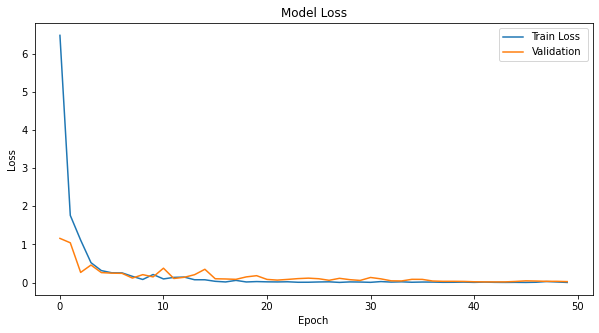

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"],  label = 'Train Loss ')
plt.plot(history.history["val_loss"],  label = 'Validation')
plt.title("Model Loss")       
plt.ylabel("Loss") 
plt.xlabel("Epoch")
plt.legend()

plt.show()
  

**Confusion matrix**

*train*

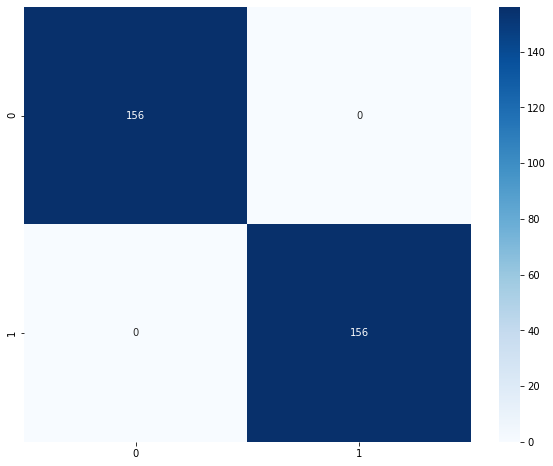

In [ ]:
import seaborn as sn

plt.figure(figsize = (10,8))
sn.heatmap(conftrain, cmap = 'Blues' ,annot=True, fmt='d')

*test*

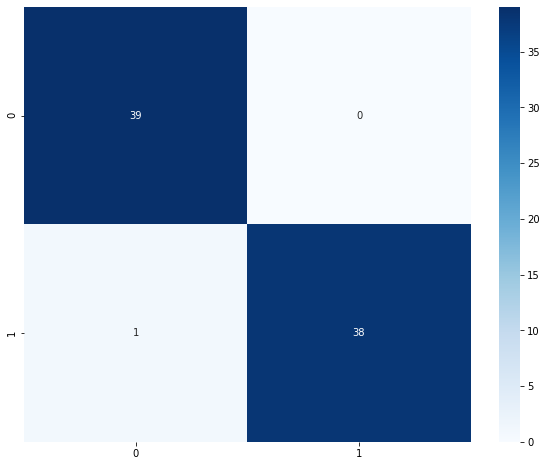

In [ ]:
import seaborn as sn

plt.figure(figsize = (10,8))
sn.heatmap(conftest, cmap = 'Blues' ,annot=True)